# Predicting Grades for Semester 2 of Second Year

In this project I try to figure out which assignments I am likely to find more difficult based on previous results.
And which ones I am likely to do well in.
I have an intuition that the computer science, stats and pratical assignments are easier than the psychology and written ones. But let's see if this is the case.

The dataset includes the following features:
- 'ModuleCode': the identifier code for the module
- 'ModuleName': the name of the module
- 'ModuleType': the field the assessment belongs to (computer science, psychology etc)
- 'AssessmentName': the name of the assessment
- 'DueDate': the date and time the assessment was due
- 'AssessmentType': whether the assessment was an exam or continuous assessment
- 'SubmissionType': what activity the assessment primarily consisted of (written, programming etc)
- 'Score': The grade achieve for the assessment
- 'CreditsWeight': the weight of the assessment for the modules overall score (100 marks is equal to a 5 credit module)
- 'Submitted': the time the assessment was submitted online

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
grades = pd.read_csv("grades.csv", sep="\t", encoding="unicode-escape")

In [3]:
unique_modules = grades['ModuleName'].unique()
for module in unique_modules:
    print(module)
    
print(len(unique_modules), 'modules') # should be 17

Systems Organisation
Human Centred Computing
Introduction to Programming & Problem-Solving
Relational Databases
User Experience Design
Research Methods in Psychology I
People & Technology
Research Design & Statistical Analysis
Neuroscience, Attention & Perception
Social Psychology
Web Development
Intermediate Programming & Problem-Solving I
Experimental Design and Statistical Applications II
Psychology of Childhood and Adolescence
Applied Cognition
Research Methods in Psychology II
16 modules


I missed a module when I was inputting the data to the excel sheet. Let me just fix that quick

In [4]:
missing_module = pd.DataFrame([
    ["CS2512","Authoring","Computer Science","Assignment 1","13 Nov 2021 23:30","CA","Written",77,30,"13 Nov 2021 19:56"],
["CS2512","Authoring","Computer Science","Assignment 2","27 Nov 2021 23:30","CA","Programming",83,35,"26 Nov 2021 12:02"],
["CS2512","Authoring","Computer Science","Assignment 3","5 Dec 2021 23:30","CA","Programming",71,35,"28 Nov 2021 16:35",]
], columns=["ModuleCode","ModuleName","ModuleType","AssessmentName","DueDate","AssessmentType","SubmissionType","Score","CreditsWeight","Submitted"])

In [5]:
missing_module

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted
0,CS2512,Authoring,Computer Science,Assignment 1,13 Nov 2021 23:30,CA,Written,77,30,13 Nov 2021 19:56
1,CS2512,Authoring,Computer Science,Assignment 2,27 Nov 2021 23:30,CA,Programming,83,35,26 Nov 2021 12:02
2,CS2512,Authoring,Computer Science,Assignment 3,5 Dec 2021 23:30,CA,Programming,71,35,28 Nov 2021 16:35


In [6]:
grades = pd.concat([grades, missing_module], ignore_index=True, axis="index")

In [7]:
grades.tail(5)

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments
52,AP2044,Applied Cognition,Psychology,Written Exam,15 Dec 2021 by 18:36,Exam,Written,65,100,15 Dec 2021 at 18:02,NaN
53,AP2114,Research Methods in Psychology II,Psychology,Assignment 1: Thematic Analysis,12/10/2021 11:00,CA,Written,68,50,12/10/2021 07:30,NaN
54,CS2512,Authoring,Computer Science,Assignment 1,13 Nov 2021 23:30,CA,Written,77,30,13 Nov 2021 19:56,NaN
55,CS2512,Authoring,Computer Science,Assignment 2,27 Nov 2021 23:30,CA,Programming,83,35,26 Nov 2021 12:02,NaN
56,CS2512,Authoring,Computer Science,Assignment 3,5 Dec 2021 23:30,CA,Programming,71,35,28 Nov 2021 16:35,NaN


Everything is looking good so far. Notice the different time formats. Let's deal with that!

In [8]:
from datetime import datetime

In [9]:
date_formats = ("%d %b %Y by %H:%S", "%d %b %Y at %H:%S", "%d/%m/%Y %H:%S", "%d %b %Y %H:%S")
issues = []
def parse(date):
    for date_format in date_formats:
        try:
            return datetime.strptime(date, date_format).strftime("%d/%m/%Y %H:%S")
        except ValueError:
            issues.append(date)
    
print(issues)

grades["DueDate"] = grades["DueDate"].apply(lambda date: parse(date))

[]


In [10]:
grades["DueDate"] = pd.to_datetime(grades["DueDate"], dayfirst=True)
grades["Submitted"] = pd.to_datetime(grades["Submitted"], dayfirst=True)

Let's sort the assignments by the time they were submitted

In [11]:
grades = grades.sort_values("Submitted")

In [12]:
grades.head()

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments
14,CS1021,Relational Databases,Computer Science,Lab Assignment 1,2020-10-23 23:59:00,CA,Programming,83,6,2020-10-19 16:20:00,NaN
22,AP1104,Research Methods in Psychology I,Psychology,Prac 1 Research Paper Worksheet,2020-11-09 18:00:00,CA,Written,70,10,2020-10-31 08:41:00,NaN
0,CS1111,Systems Organisation,Computer Science,Assessment 1 - Overview Material Questions,2020-11-08 23:59:00,CA,Written,100,10,2020-11-07 08:50:00,NaN
32,AP1040,Research Design & Statistical Analysis,Statistics,Assignment 1,2020-11-09 11:00:00,CA,Written,87,10,2020-11-08 08:29:00,NaN
15,CS1021,Relational Databases,Computer Science,Lab Assignment 2,2020-11-14 23:59:00,CA,Programming,83,6,2020-11-08 13:24:00,NaN


# Exploratory Analysis

I want to find my average score overall
but getting the mean of the scores doesn't account for the fact that the assignments are worth different amounts of credit

In [13]:
round(grades['Score'].mean(),2) 

82.72

so the 82% is inflated. Fortunately the CreditsWeight column lets us deal with that.

In [14]:
grades["NumberCreditsEarned"] = grades["CreditsWeight"] * (grades["Score"] / 100)
round(grades["NumberCreditsEarned"].sum() / grades["CreditsWeight"].sum(),2) * 100

78.0

In [15]:
# here's a more succint syntax
np.average(grades["Score"] ,weights=grades["CreditsWeight"])

77.6128

78% is not bad at all. 

If we look at the median, we see the distribution is negatively skewed.

In [16]:
grades['Score'].median()

84.0

<AxesSubplot:ylabel='Density'>

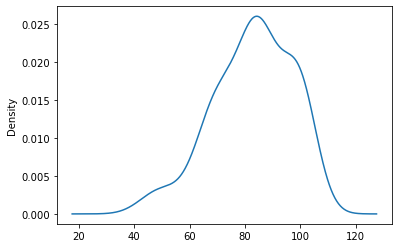

In [17]:
grades["Score"].sort_values().plot(kind="kde")

### How do each of the semesters compare?

In [18]:
# Semester 1
semester1_credits_earned = grades[grades["DueDate"].between("2020-9-01","2020-12-31")]["NumberCreditsEarned"].sum()
semester1_credits_total = grades[grades["DueDate"].between("2020-9-01","2020-12-31")]["CreditsWeight"].sum()
round(semester1_credits_earned / semester1_credits_total,2)

0.79

In [19]:
# Semester 2
semester2_credits_earned = grades[grades["DueDate"].between("2021-1-1","2021-6-1")]["NumberCreditsEarned"].sum()
semester2_credits_total = grades[grades["DueDate"].between("2021-1-1","2021-6-1")]["CreditsWeight"].sum()
round(semester2_credits_earned / semester2_credits_total,2)

0.78

In [20]:
# Semester 3
semester3_credits_earned = grades[grades["DueDate"].between("2021-9-1","2021-12-31")]["NumberCreditsEarned"].sum()
semester3_credits_total = grades[grades["DueDate"].between("2021-9-1","2021-12-31")]["CreditsWeight"].sum()
round(semester3_credits_earned / semester3_credits_total,2)

0.77

It looks like each semester is getting progressively harder, as expected.

I want to see if we can shift that distribution by focusing on my weakest points.

Let's see what my 10 worst grades have been so far.

In [21]:
worst_grades = grades["Score"].nsmallest(10).index

In [22]:
grades.loc[worst_grades]

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments,NumberCreditsEarned
44,CS2012,Web Development,Computer Science,Class Test,2021-12-03 11:30:00,Exam,Quiz,45,25,2021-12-03 10:16:00,NaN,11.25
6,CS1111,Systems Organisation,Computer Science,Class Test,2020-12-17 16:00:00,Exam,Written,50,40,2020-12-17 15:44:00,NaN,20.00
38,AP1035,"Neuroscience, Attention & Perception",Psychology,Essay 1,2021-05-04 18:00:00,CA,Written,52,50,2021-05-04 12:21:00,NaN,26.00
40,AP1022,Social Psychology,Psychology,Essay,2021-04-30 15:00:00,CA,Written,62,100,2021-04-30 10:32:00,NaN,62.00
39,AP1035,"Neuroscience, Attention & Perception",Psychology,Essay 2,2021-05-04 18:00:00,CA,Written,62,50,2021-05-04 12:21:00,NaN,31.00
52,AP2044,Applied Cognition,Psychology,Written Exam,2021-12-15 18:36:00,Exam,Written,65,100,2021-12-15 18:02:00,NaN,65.00
31,AP1046,People & Technology,Psychology,Assignment 2,2020-12-14 11:00:00,CA,Written,68,50,2020-12-11 09:58:00,NaN,34.00
53,AP2114,Research Methods in Psychology II,Psychology,Assignment 1: Thematic Analysis,2021-10-12 11:00:00,CA,Written,68,50,2021-10-12 07:30:00,NaN,34.00
49,AP2046,Experimental Design and Statistical Applicatio...,Statistics,Practical Report,2021-12-13 11:00:00,CA,Written,68,50,2021-12-12 11:25:00,NaN,34.00
51,AP2045,Psychology of Childhood and Adolescence,Psychology,Essay,2021-12-21 11:00:00,CA,Written,68,100,2021-12-21 05:21:00,NaN,68.00


With the exception of two computer science assessments (both of which were exams) it appears overall psychology is my weakest area. But let's confirm this.

In [23]:
grades["ModuleType"] = grades["ModuleType"].astype("category")
grades["AssessmentType"] = grades["AssessmentType"].astype("category")
grades["SubmissionType"] = grades["SubmissionType"].astype("category")

In [24]:
grades.groupby("ModuleType")["Score"].mean().sort_values()

ModuleType
Psychology          72.437500
UX                  75.000000
Statistics          85.000000
Computer Science    88.827586
Name: Score, dtype: float64

In [25]:
grades.groupby("AssessmentType")["Score"].mean().sort_values()

AssessmentType
Exam    71.625000
CA      84.530612
Name: Score, dtype: float64

In [26]:
grades.groupby("SubmissionType")["Score"].mean().sort_values()

SubmissionType
Written         74.240000
Quiz            81.428571
Presentation    84.000000
Programming     91.875000
Name: Score, dtype: float64

Based on this analysis. Written psychology exams are the weak spot. Not surprising really. 
Practical computer science continuous assessments are the strongest. 💪🏻

I just submitted a python assignment. What mark can I hope to get on average based on previous python modules?

In [27]:
python_modules = grades["ModuleName"].isin(["Introduction to Programming & Problem-Solving","Intermediate Programming & Problem-Solving I"])

In [28]:
round(grades[python_modules]["NumberCreditsEarned"].sum() / grades[python_modules]["CreditsWeight"].sum() * 100,2)

87.92

Answer: about 88%

# Building the Logistic Regression Model

Let's see if we can build a model to predict future grades.

First we need to deal with some of the categorical values by turning them into dummy variables making sure to deal with multicollinearity and scale the variables.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [30]:
cat_features = ["ModuleType","AssessmentType","SubmissionType"]
grades_dummies = pd.get_dummies(grades, columns=cat_features, drop_first=True)

In [31]:
X = grades_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']]
y = grades_dummies['Score']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=28)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [33]:
predictions = pipe.predict(X_test)

As we can see below the model did a pretty terrible job of predicting correctly from the data provided. Using categorical values to predict a numerical output means theres a lot of noise. For my purposes 100% accuracy is not neccessary. A ball park figure is good enough to take action on.

In [34]:
print(classification_report(y_test,predictions, zero_division=0))

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          62       0.00      0.00      0.00         1
          68       0.50      1.00      0.67         2
          71       0.00      0.00      0.00         2
          73       0.00      0.00      0.00         1
          74       0.00      0.00      0.00         0
          77       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         0
          80       1.00      1.00      1.00         1
          81       0.00      0.00      0.00         2
          83       0.00      0.00      0.00         1
          84       0.00      0.00      0.00         1
          85       1.00      1.00      1.00         1
          87       0.00      0.00      0.00         1
          88       0.00      0.00      0.00         0
          90       0.00      0.00      0.00         1
          97       0.00      0.00      0.00         0
         100       0.67    

# How Will Semester 2 Go?

In [35]:
semester_2 = pd.read_csv("semester2.csv")

In [36]:
semester_2_dummies = pd.get_dummies(semester_2, columns=cat_features)

In [37]:
predicted_grades = semester_2_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']]
semester_2['Predicted'] = pipe.predict(predicted_grades)

These are the assignments most likely to give me trouble this semester.

In [38]:
semester_2[["ModuleName","AssessmentName", "Predicted"]].sort_values("Predicted").head(7)

,ModuleName,AssessmentName,Predicted
1,Learning & Behaviour,MCQ,45
0,Learning & Behaviour,Essay,68
2,Research Methods in Psychology II,Prac 4 Experiment,68
3,Research Methods in Psychology II,Prac 5 Research Proposal,68
5,Social Computing,Blogs,68
6,Social Computing,Social Analysis Report,68
11,Design for Human Centred Computing,Project Assignment 1,74


In [39]:
semester_2["PredictedCreditsEarned"] = semester_2["CreditsWeight"] * (semester_2["Predicted"] / 100)
round(semester_2["PredictedCreditsEarned"].sum() / semester_2["CreditsWeight"].sum(),2) * 100

73.0

According to the model I should get an average grade of 73%

Although I am a little surprised by the prediction for the Learning & Behavior MCQ

In [40]:
quizzes = grades[grades["SubmissionType"] == 'Quiz']
quizzes[["ModuleName", "ModuleType","AssessmentType","CreditsWeight","Score"]]

,ModuleName,ModuleType,AssessmentType,CreditsWeight,Score
9,Introduction to Programming & Problem-Solving,Computer Science,CA,15,85
10,Introduction to Programming & Problem-Solving,Computer Science,CA,20,85
34,Research Design & Statistical Analysis,Statistics,CA,10,85
35,Research Design & Statistical Analysis,Statistics,CA,10,100
36,Research Design & Statistical Analysis,Statistics,CA,10,90
44,Web Development,Computer Science,Exam,25,45
50,Experimental Design and Statistical Applicatio...,Statistics,Exam,50,80


Overall I didn't do too badly in quizzes. 
The model seems to have a lot of room for improvement and I have a lot to learn.

In [41]:
semester_2[["ModuleName","Predicted"]].groupby("ModuleName").mean().sort_values("Predicted")

,Predicted
ModuleName,
Learning & Behaviour,56.500000
Social Computing,68.000000
Research Methods in Psychology II,73.666667
Design for Human Centred Computing,74.000000
Intermediate Programming & Problem Solving II,96.250000


## Conclusion
I know Dr Linehan can be a tough marker. I'll put a little extra attention in Learning & Behavior. My intuition about psychology versus computer science seems to be right and this semesters focus on more written psychology will make it just that little bit harder than last semester. But I am ready for it.

## Update
since developing the model, I have gotten some results back.
Let's see how well the model performed.

* For Research Methods in Psychology II - Prac 4 Experiment, the model predicted as score of 68%.
Actual result: 78%

# Neural Net
Let's see if a neural net performs any better

In [43]:
X = grades_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']].values
y = grades_dummies['Score'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler()

In [47]:
scaler.fit(X_train)

MinMaxScaler()

In [48]:
X_train = scaler.transform(X_train)

In [49]:
X_test = scaler.transform(X_test)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [51]:
model = Sequential()

model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

In [52]:
model.fit(x=X_train, y=y_train, epochs=500)

Epoch 1/500
2/2 [==============================] - 0s 2ms/step - loss: 7455.5884
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 7438.8062
Epoch 3/500
2/2 [==============================] - 0s 1ms/step - loss: 7427.2437
Epoch 4/500
2/2 [==============================] - 0s 2ms/step - loss: 7418.2109
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 7410.4565
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 7402.6729
Epoch 7/500
2/2 [==============================] - 0s 996us/step - loss: 7395.8315
Epoch 8/500
2/2 [==============================] - 0s 1ms/step - loss: 7389.4263
Epoch 9/500
2/2 [==============================] - 0s 1ms/step - loss: 7382.8672
Epoch 10/500
2/2 [==============================] - 0s 1ms/step - loss: 7376.7710
Epoch 11/500
2/2 [==============================] - 0s 1ms/step - loss: 7370.7446
Epoch 12/500
2/2 [==============================] - 0s 1ms/step - loss: 7364.8438
Epoch 13/500
2/2 [=====

<AxesSubplot:>

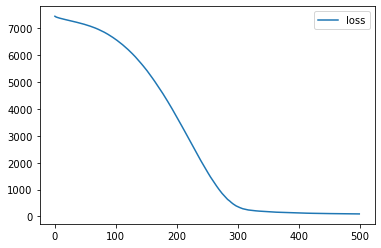

In [53]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [54]:
model.evaluate(X_test, y_test, verbose=0)

360.6325988769531

In [55]:
model.evaluate(X_train, y_train, verbose=0)

94.0910873413086

In [56]:
test_predictions = model.predict(X_test)

In [57]:
test_predictions = pd.Series(test_predictions.reshape(18,))

In [58]:
prediction_df = pd.DataFrame(y_test, columns=["Test True Y"])

In [59]:
prediction_df = pd.concat([prediction_df, test_predictions], axis=1)

In [60]:
prediction_df.rename(columns={prediction_df.columns[1] : "Model Predictions"} , inplace=True)

In [61]:
prediction_df

,Test True Y,Model Predictions
0,62,73.657486
1,77,53.137882
2,71,114.465744
3,50,48.564217
4,68,71.493370
5,84,65.322830
6,80,70.448189
7,100,52.272243
8,81,71.060547
9,90,73.723389


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [63]:
mean_absolute_error(prediction_df["Test True Y"], prediction_df["Model Predictions"])

14.050234900580513

In [64]:
mean_squared_error(prediction_df["Test True Y"], prediction_df["Model Predictions"]) **0.5

18.990329909643958

In [65]:
semester2 = scaler.transform(predicted_grades)

D:\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [66]:
semester_2["Neural_Net_Predictions"] = model.predict(semester2)

In [67]:
semester_2[["ModuleName","AssessmentName", "Predicted", "Neural_Net_Predictions"]]

,ModuleName,AssessmentName,Predicted,Neural_Net_Predictions
0,Learning & Behaviour,Essay,68,71.493370
1,Learning & Behaviour,MCQ,45,82.924576
2,Research Methods in Psychology II,Prac 4 Experiment,68,75.454689
3,Research Methods in Psychology II,Prac 5 Research Proposal,68,71.493370
4,Research Methods in Psychology II,Prac 6 Presentation,85,62.115917
5,Social Computing,Blogs,68,71.493370
6,Social Computing,Social Analysis Report,68,71.493370
7,Intermediate Programming & Problem Solving II,Project Part 1,100,93.552567
8,Intermediate Programming & Problem Solving II,Project Part 2,100,92.903328
9,Intermediate Programming & Problem Solving II,Project Part 3,100,93.552567


Interestingly, the model seems to think the general trend is to lose a percentage each semester, even without adding time data

In [ ]:
from tensorflow.keras.models import load_model
model.save("predict_grades.h5")

## Update
since developing the model, I have gotten some results back.
Let's see how well the model performed.

* For Research Methods in Psychology II - Prac 4 Experiment, the model predicted as score of 75%.
Actual result: 78%.